In [782]:
import numpy as np
import QuantLib as ql
import matplotlib.pyplot as plt

In [783]:
day_count=ql.Actual365Fixed()
calendar=ql.NullCalendar()

calculation_date = ql.Date(2,ql.January,2026)
spot = 93799.067
ql.Settings.instance().evaluationDate = calculation_date

risk_free_rate = [0.03639,0.03710,0.03639,0.03622,0.03485]  #02/01/2026 0D,1D,3M,6M,1Y
risk_free_rate_date = [ql.Date(2,ql.January,2026),
                       ql.Date(3,ql.January,2026),
                       ql.Date(2,ql.April,2026),
                       ql.Date(2,ql.July,2026),
                       ql.Date(2,ql.January,2027)]
zero_curve_ts = ql.YieldTermStructureHandle(
    ql.ZeroCurve(risk_free_rate_date, risk_free_rate, day_count, calendar)
)
dividend_rate = 0.0
dividend_yield_ts = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, dividend_rate, day_count))

In [784]:
# dummy Heston parameters
# v0 = 0.32, kappa = 2.54, theta = 0.13, sigma = 0.32, rho = 0.1, t = 55.0 / 365.0 
v0 = 0.0576
kappa = 2.25
theta = 0.05
sigma = 0.24
rho = -0.3
t = 78.0 / 365.0


Heston_process = ql.HestonProcess(
    (zero_curve_ts),
    (dividend_yield_ts),
    ql.QuoteHandle(ql.SimpleQuote(spot)),
    v0, kappa, theta, sigma, rho
)
Heston_model = ql.HestonModel(Heston_process)
AHE = ql.AnalyticHestonEngine(Heston_model)

In [785]:
#Expiration dates and strikes
expiration_dates =[ql.Date(27,ql.February,2026),
                    ql.Date(27,ql.March,2026)]
strikes = [75000, 95000, 100000, 110000, 120000]
data = [[0.52828789, 0.42910755, 0.42198479, 0.42694569, 0.44228017], 
        [0.51148415, 0.4310441, 0.42707086, 0.42592227, 0.43286622]]

implied_vols = ql.Matrix(len(strikes), len(expiration_dates))
for i in range(len(expiration_dates)):      # 日期循环 (行)
    for j in range(len(strikes)):          # 行权价循环 (列)
        implied_vols[j][i] = data[i][j]

black_variance_surface = ql.BlackVarianceSurface(
    calculation_date, calendar,
    expiration_dates, strikes,
    implied_vols, day_count)

black_variance_surface.enableExtrapolation()

#[0.4932, 0.4725, 0.49788898, 0.45910323, 0.44885623, ],

#
#

In [786]:
target_date = calculation_date + ql.Period(171, ql.Days)

black_variance_surface.enableExtrapolation()


for i in range(len(strikes)):
    vol_value = black_variance_surface.blackVol(target_date, strikes[i])
    vol_handle = ql.QuoteHandle(ql.SimpleQuote(vol_value))
    heston_helper = ql.HestonModelHelper(
            ql.Period(171, ql.Days),
            calendar,
            spot,
            strikes[i],
            vol_handle,
            zero_curve_ts,
            dividend_yield_ts
        )

    heston_helper.setPricingEngine(AHE)
    Heston_model.calibrate([heston_helper], ql.Simplex(1e-4), ql.EndCriteria(1000, 500, 1e-8, 1e-8, 1e-8))
    params = Heston_model.params()
    theta = params[0]
    kappa = params[1]
    sigma = params[2]
    rho = params[3]
    v0 = params[4]
    print("Calibrated Heston parameters:theta = %f, kappa = %f, sigma = %f, rho = %f, v0 = %f" % (theta, kappa, sigma, rho, v0))

Calibrated Heston parameters:theta = 0.248613, kappa = 2.118969, sigma = 0.187857, rho = -0.380776, v0 = 0.262347
Calibrated Heston parameters:theta = 0.247508, kappa = 2.125190, sigma = 0.230710, rho = -0.361185, v0 = 0.153472
Calibrated Heston parameters:theta = 0.247822, kappa = 2.125725, sigma = 0.231970, rho = -0.360696, v0 = 0.150229
Calibrated Heston parameters:theta = 0.249342, kappa = 2.124061, sigma = 0.230973, rho = -0.360964, v0 = 0.151957
Calibrated Heston parameters:theta = 0.257181, kappa = 2.115135, sigma = 0.225993, rho = -0.361917, v0 = 0.160422


June:Calibrated Heston parameters:theta = 0.960714, kappa = 1.193527, sigma = 1.296894, rho = 0.072377, v0 = 0.196587

else:Calibrated Heston parameters:theta = 1.322046, kappa = 1.212397, sigma = 1.378812, rho = -0.353751, v0 = 0.162918

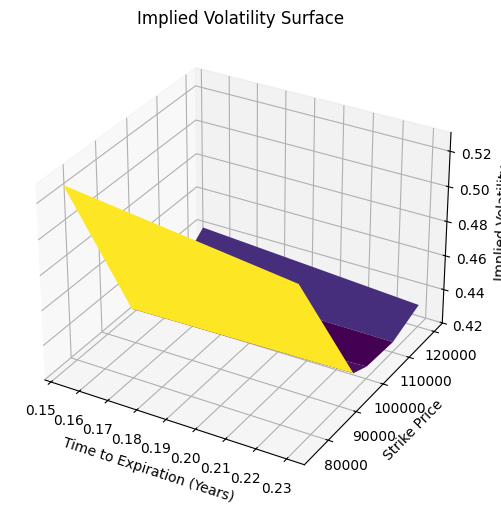

In [787]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(
    [ql.Actual365Fixed().yearFraction(calculation_date, d) for d in expiration_dates],
    strikes
)
Z = np.array([[black_variance_surface.blackVol(
    ql.Actual365Fixed().yearFraction(calculation_date, expiration_dates[j]),
    strikes[i]
) for j in range(len(expiration_dates))] for i in range(len(strikes))])
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel('Time to Expiration (Years)')
ax.set_ylabel('Strike Price')
ax.set_zlabel('Implied Volatility')
ax.set_title('Implied Volatility Surface')
plt.show()

In [788]:
print(ql.Actual365Fixed().yearFraction(calculation_date, expiration_dates[0]))


0.15342465753424658


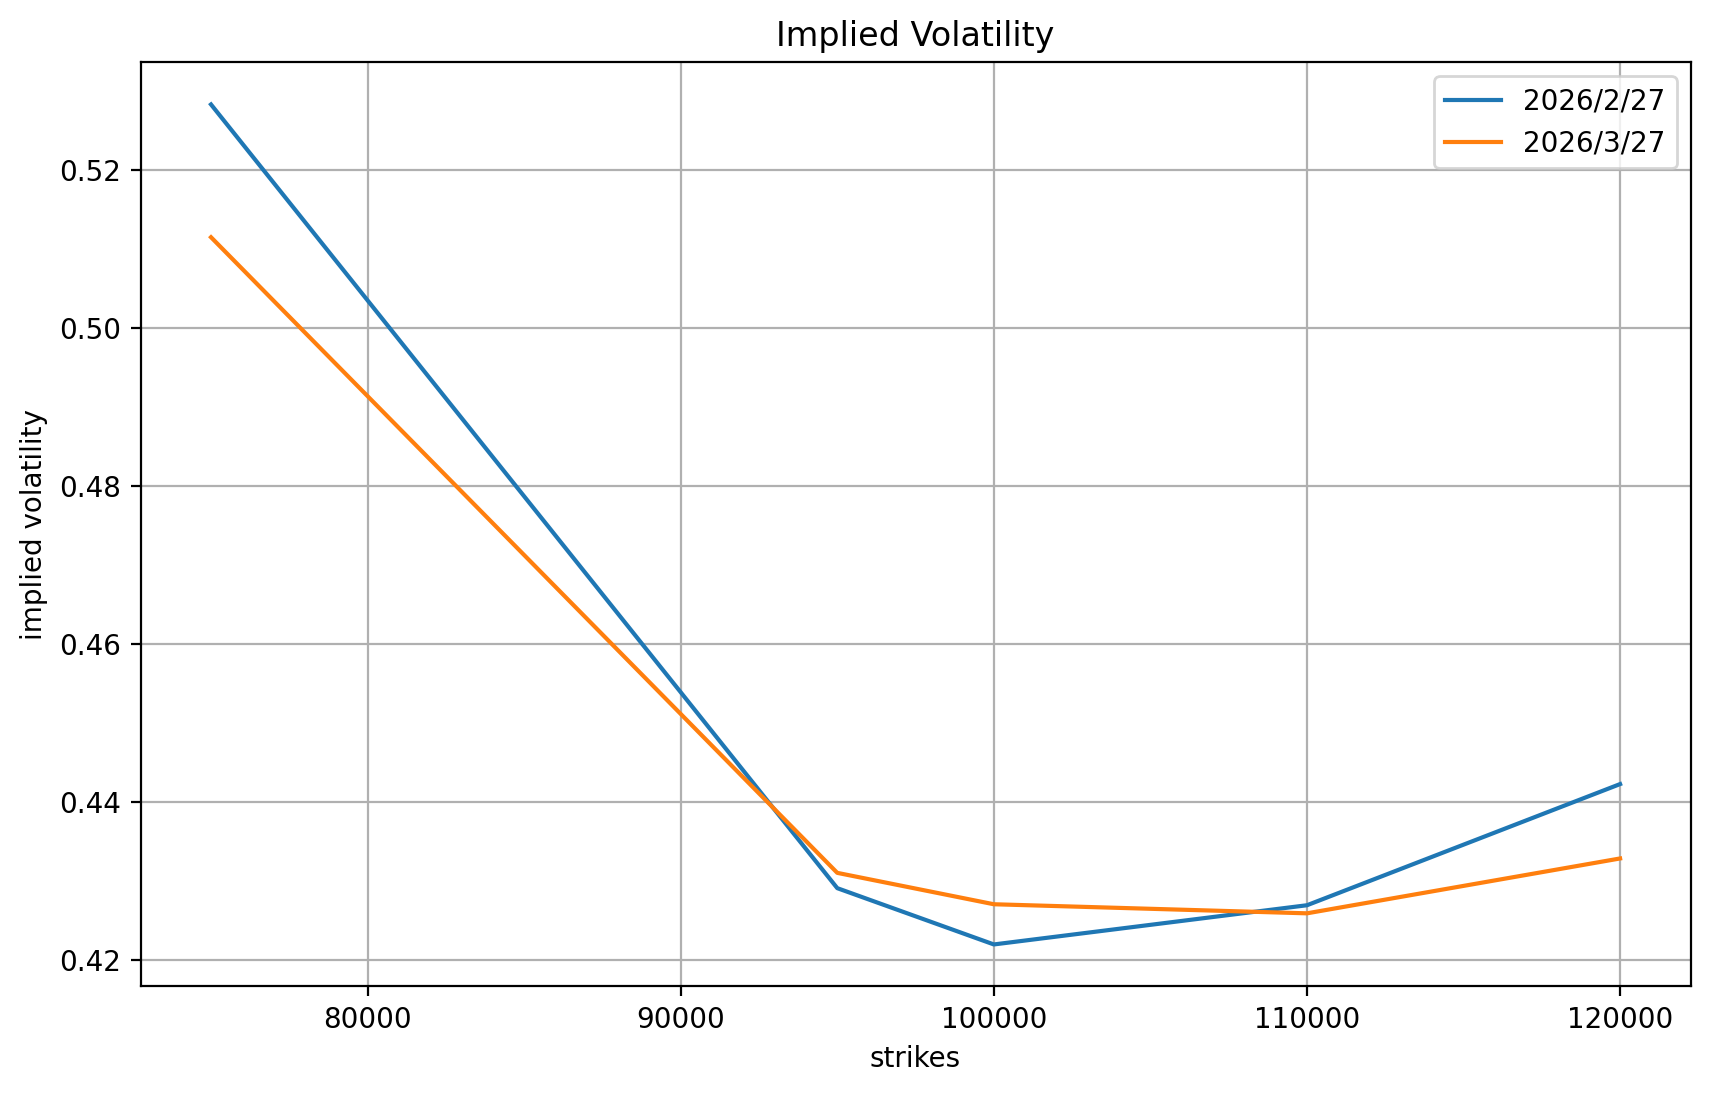

In [789]:
plt.figure(figsize=(10, 6), dpi = 200)
# Extract implied volatilities for the first expiration date
ivs = [black_variance_surface.blackVol(expiration_dates[0], strike) for strike in strikes]
plt.plot(strikes, data[0], '-', label='2026/2/27')
plt.plot(strikes, data[1], '-', label='2026/3/27')
plt.xlabel('strikes')
plt.ylabel('implied volatility')
plt.title('Implied Volatility')
plt.legend()
plt.grid(True)
plt.show()


In [790]:
Heston_process = ql.HestonProcess(
    zero_curve_ts,
    dividend_yield_ts,
    ql.QuoteHandle(ql.SimpleQuote(spot)),
    v0,
    kappa,
    theta,
    sigma,
    rho
)
Heston_model = ql.HestonModel(Heston_process)
AHE = ql.AnalyticHestonEngine(Heston_model)

In [791]:
helpers = []
for s in [strike for strike in strikes]:
    v = black_variance_surface.blackVol(t, s)
    helper = ql.HestonModelHelper(ql.Period(25, ql.Days), calendar, spot, s, 
                                 ql.QuoteHandle(ql.SimpleQuote(v)), 
                                 zero_curve_ts, dividend_yield_ts)
    helper.setPricingEngine(AHE)
    helpers.append(helper)

#Heston_model.calibrate(helpers, ql.LevenbergMarquardt(), ql.EndCriteria(1000, 500, 1e-8, 1e-8, 1e-8))

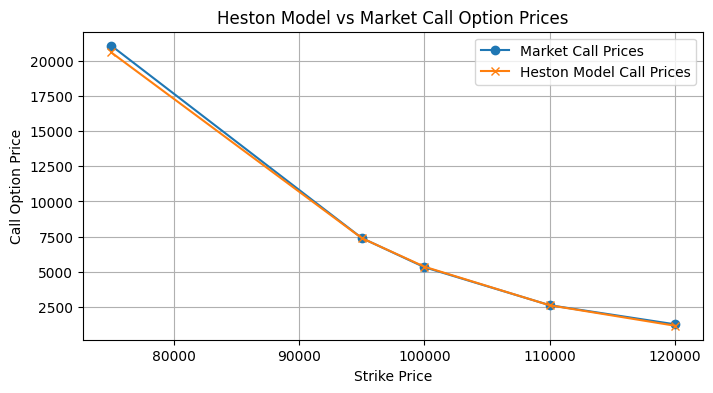

        Strikes    Marking Data    Heston Model    Relative Error(%)
          75000           21055         20574.1           -2.28
          95000            7405          7397.9            -0.1
         100000            5335          5371.9            0.69
         110000            2640          2634.9           -0.19
         120000            1285          1184.2           -7.85
Error: 2.22(%)


In [ ]:
maturity = ql.Date(27,ql.March,2026)
strikes = [75000, 95000, 100000, 110000, 120000]
call_prices = [21055, 7405, 5335, 2640, 1285]
call_Heston = []
for i in strikes:
    vanilla_payoff = ql.PlainVanillaPayoff(ql.Option.Call, i)
    Euro_Option = ql.VanillaOption(vanilla_payoff, ql.EuropeanExercise(maturity))
    Euro_Option.setPricingEngine(AHE)
    call_Heston.append(Euro_Option.NPV())

fig = plt.figure(dpi = 100, figsize=(8,4))
plt.plot(strikes, call_prices, label='Market Call Prices', marker='o')
plt.plot(strikes, call_Heston, label='Heston Model Call Prices', marker='x')
plt.xlabel('Strike Price')
plt.ylabel('Call Option Price')
plt.title('Heston Model vs Market Call Option Prices')
plt.legend()
plt.grid()
plt.show()   


avg = 0.0
print("%15s %15s %15s %20s" % ("Strikes", "Marking Data", "Heston Model", "Relative Error(%)"))
print("="*100)
for i in range(len(strikes)):
    err = (call_Heston[i]/call_prices[i] - 1.0)
    print("%15s %15s %15s %15s" % (strikes[i], call_prices[i], round(call_Heston[i],1), round(100.0*err, 2)))
    avg += abs(err)*100/len(strikes)
print("="*100)
print("Error: " + str(round(avg, 2)) + '(%)')


errors = []
for i in range(len(strikes)):
    mkt = call_prices[i]
    mdl = call_Heston[i]
    errors.append(abs(mkt - mdl) / mkt)

ValueError: x and y must have same first dimension, but have shapes (21,) and (23,)

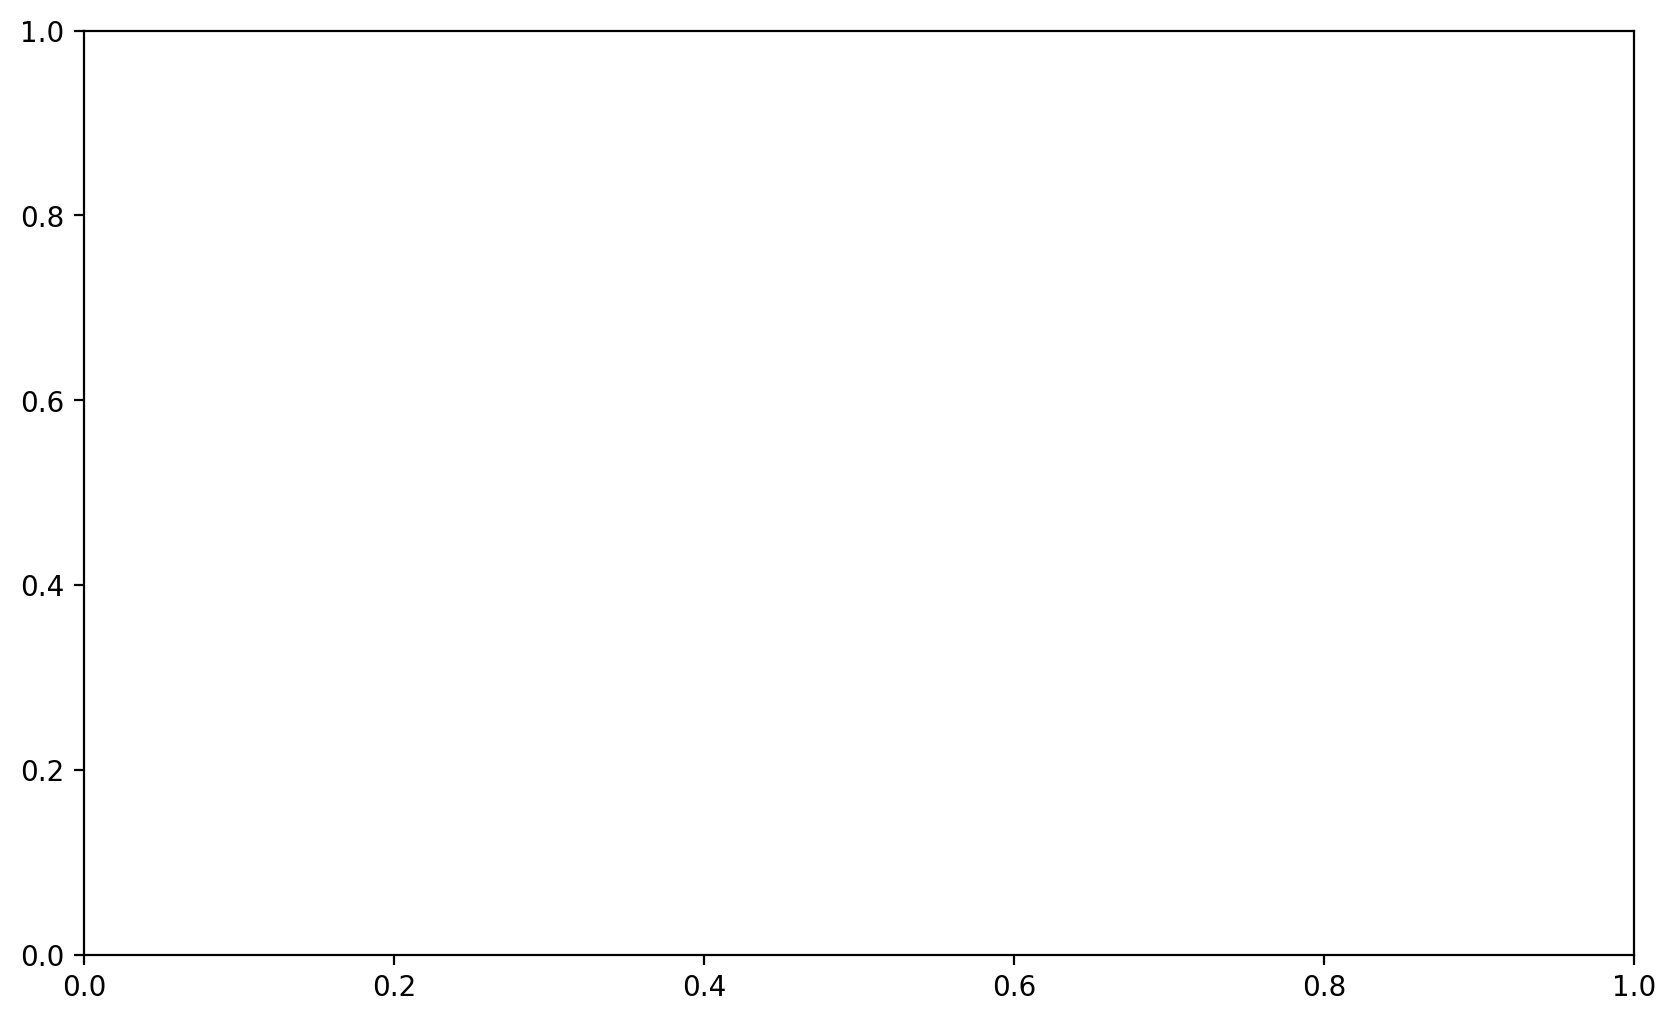

In [793]:
# maturity = ql.Date(26,ql.June.2026) Calibration 
maturity = ql.Date(26,ql.June,2026)
strikes = [70000,75000,80000,85000,90000,95000,100000,105000,110000,115000,120000,125000,130000,135000,140000,145000,150000,155000,160000,165000,170000]
data = [0.6165,0.522,0.4932,0.50120243,0.4725,0.4644,0.49788898,0.4536,0.45236835,0.44829205,0.45910323,0.44802732,0.44994984,0.45476732,0.44885623,0.44420263,0.44700762,0.45059186,0.46162649,0.4583505,0.47163852,0.47429108,0.49057582]
plt.figure(figsize=(10, 6), dpi = 200)
plt.plot(strikes, data, '-', label='Market Implied Volatility')
ivs = [black_variance_surface.blackVol(maturity, strike) for strike in strikes]
plt.plot(strikes, ivs, '-', label='Heston Model Implied Volatility')
plt.xlabel('Strikes')
plt.ylabel('Implied Volatility')
plt.title('Heston Model Calibration Result')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
strikes = [70000, 80000, 90000, 110000, 130000]

data = [[0.58714735, 0.47514342, 0.428931, 0.45591295, 0.55579, ], 
        [0.5163465, 0.46274128, 0.43305466, 0.43173134, 0.47113603, ],
        [0.5291, 0.4922, 0.43618647, 0.42982936, 0.45105001, ],
        [0.4932, 0.4725, 0.49788898, 0.45910323, 0.44885623, ],
        [0.4977, 0.4815, 0.4707, 0.46067065, 0.44873872, ],
        [0.5168, 0.5042, 0.4952, 0.4844, 0.48982342, ]]


implied_vols[j][i] = data[j][i]
black_variance_surface = ql.BlackVarianceSurface(
    calculation_date, calendar,
    expiration_dates, strikes,
    implied_vols, day_count)
implied_vols = ql.Matrix(len(strikes), len(expiration_dates))
for j in range(len(strikes)):
    for i in range(len(expiration_dates)):

In [ ]:
70000, 80000, 90000, 110000, 130000
strikes_June = [40000,60000,70000,75000,80000,85000,90000,95000,100000,105000,110000,115000,120000,125000,130000,135000,140000,145000,150000,155000,160000,165000,170000]
data_June = [0.6165,0.522,0.4932,0.50120243,0.4725,0.4644,0.49788898,0.4536,0.45236835,0.44829205,0.45910323,0.44802732,0.44994984,0.45476732,0.44885623,0.44420263,0.44700762,0.45059186,0.46162649,0.4583505,0.47163852,0.47429108,0.49057582]